# 13-14.프로젝트 : CIFAR-10 이미지 생성하기

######  STEP 0. 작업환경 구성하기

-  mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
-  mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
-  mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

######  STEP 1. 데이터셋 구성하기

In [259]:
import tensorflow as tf
from matplotlib import pyplot as plt 
import matplotlib.pyplot as plt
%matplotlib inline

In [260]:
import os
import glob
import time

import PIL
import imageio
import numpy as np

from tensorflow.keras import layers
from IPython import display

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [261]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

###### cifar10 데이터셋

총 10개 클래스

- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck

###### 이미지 정규화 

In [262]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [263]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [264]:
train_x.shape

(50000, 32, 32, 3)

###### 학습 데이터 시각화 

In [265]:
train_x[0].shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


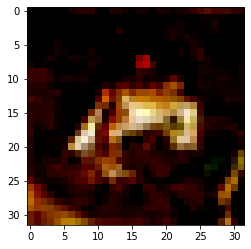

In [266]:
plt.imshow(train_x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


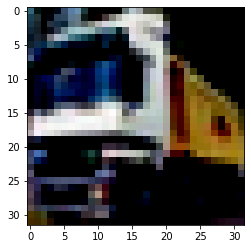

In [267]:
plt.imshow(train_x[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


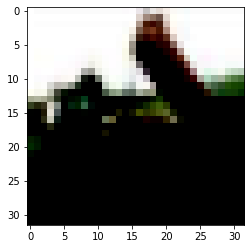

In [268]:
plt.imshow(train_x[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


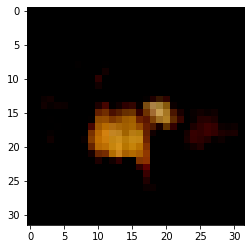

In [269]:
plt.imshow(train_x[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

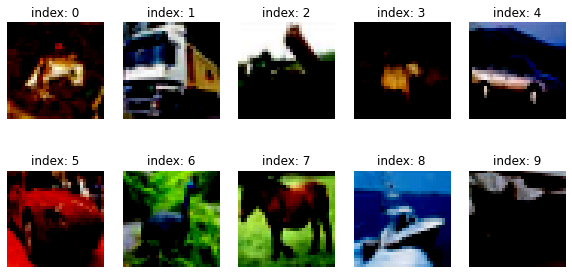

In [270]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off') # 불필요한 축을 지우기
plt.show()

###### 미니배치 데이터셋 구성 

In [271]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [272]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

######  STEP 2. 생성자 모델 구현하기

In [273]:
dir(layers)

['AbstractRNNCell',
 'Activation',
 'ActivityRegularization',
 'Add',
 'AdditiveAttention',
 'AlphaDropout',
 'Attention',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv1DTranspose',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'Convolution1D',
 'Convolution1DTranspose',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Convolution3DTranspose',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'Dense',
 'DenseFeatures',
 'DepthwiseConv2D',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'GlobalMaxPooling2D',
 'Global

In [274]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # 100개의 값을 받는다. Batch(데이터의 개수) 는 상관 없다
    model.add(layers.Dense(8*8*256*3, use_bias=False, input_shape=(100,))) 
    # 학습시켰던 데이터의 분포와 테스트하려는 데이터의 분포가 다르다면 
    # 새롭게 학습 시켜야 할 것 
    # 이러한 분포의 변화를 Covariance Shift라고 한다
    # Batch Norm은 은닉층 값들의 분포가 변화하는 양을 줄여준다
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.Activation('tanh'))
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256*3)))

    # Third: Conv2DTranspose layer
    '''
    !!! UpSampling2D와 Conv2DTranspose 차이  
    UpSampling2D는 입력 값을 반복하여 차원수를 늘려준다
    Pooling의 반대로 보면 된다    
    ex) UpSampling2D(size = (2,2))
    
    Conv2DTranspose는 UpSampling 뿐만 아니라, Convolution을 진행한다
    Convolution 연산에서 차원의 크기는 Stride의 영향을 많이 받는다.
    일반적으로 들어온 이미지 크기를 2배 해주기 위해, strides = (2,2)를 많이 사용한다
     
     '''
    # ??? 필터의 갯수 어떻게 결정해야하는지 (128*3)
    # ??? 하이퍼파라미터 수 계산 시, 필터 개수의 제곱?
    model.add(layers.Conv2DTranspose(128*3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # BatchNomalization Layer의 파라미터 수 계산
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.Activation('tanh'))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.Activation('tanh'))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

In [275]:
# 그럼 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력해 봅시다.

generator = make_generator_model()

generator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 49152)             4915200   
_________________________________________________________________
batch_normalization_36 (Batc (None, 49152)             196608    
_________________________________________________________________
activation (Activation)      (None, 49152)             0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 8, 8, 768)         0         
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 8, 8, 384)         7372800   
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 8, 384)         1536      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 384)       

In [276]:
# 평균 0, 분산 1을 가지는 random 100개 생성
noise = tf.random.normal([1, 100])

In [277]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

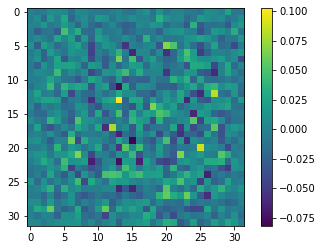

In [278]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

######  STEP 3. 판별자 모델 구현하기

In [279]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [280]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)            

In [281]:
generated_image

<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[-1.4267473e-03, -1.8029021e-03,  1.1974776e-03],
         [-6.0987333e-03, -4.9788537e-03, -1.5108864e-03],
         [-6.8932893e-03, -3.8532347e-03, -3.8904906e-03],
         ...,
         [ 2.4189610e-02, -7.0929080e-03, -2.9140085e-03],
         [-7.4216817e-03,  1.5310253e-03,  6.0769417e-03],
         [-8.6245984e-03,  1.0318828e-03, -8.5967919e-03]],

        [[-2.7739168e-03, -9.6713047e-04, -5.0005750e-03],
         [ 7.5123622e-03, -1.1739391e-03,  1.4991189e-02],
         [-1.6861361e-02, -6.6671595e-03, -1.0456312e-03],
         ...,
         [-1.3438813e-02, -2.0825669e-02, -1.0605112e-02],
         [-7.0142695e-03, -9.0605821e-03, -5.3086627e-04],
         [ 8.3550597e-03, -5.5182929e-04,  2.7196480e-02]],

        [[ 1.0749078e-03, -1.6077938e-03, -8.5680722e-04],
         [ 1.3464992e-03, -2.3654923e-02,  5.8681006e-05],
         [ 1.6481230e-02, -1.5521024e-02, -9.3020167e-04],
         ...,
         [-3.

In [282]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00328785]], dtype=float32)>

######  STEP 4. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [283]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [284]:
# ??? tf.ones_like()로 구한 텐서와 cross_entropy를 구한 것이 무슨 의미가 있지?
# fake_output의 shape는  (None, 1)
# None은 표기는 안되어있지만, 향후 학습 과정에서 이미지 배치 내 이미지 개수를 의미한다
# !!! Generator_loss는 말 그대로, fake_output이라는 random값을 입력시켜 Generator로 생성한 이미지의
# Discriminator에 의한 판별 값이 Disriminator에 의해 실제 이미지('1')라고 판별될 분포를 근사하도록 하는 것이다
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [285]:
def discriminator_loss(real_output, fake_output):
    # Discriminator에 실제 이미지를 넣어 나온 값이 Discriminator가 실제 이미지('1')라고 판별하는 분포를 근사하게 만든다
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake_output이라는 random값을 입력시켜 Generator로 생성한 이미지의
    # Discriminator에 의한 판별 값이 Disriminator에 의해 가짜 이미지('0')라고 판별될 분포를 근사하도록 하는 것이다
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [286]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    # !!! tf.math.less()
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [287]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 학습률 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) 

In [288]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

######  STEP 5. 훈련과정 상세 기능 구현하기

In [289]:
# 텐서플로우 아키텍처
'''
https://www.youtube.com/watch?v=UwOiS6WW7DA

텐서플로우는 수식을 그래프로 변환하고,
세션에서 그래프를 실행하여 수식 계산 결과를 얻는다

텐서플로우에서 그래프로 변환하려면 
노드와 엣지로 변환하여야 한다

노드는 Operation
ex) matmul , add

엣지는 Tensor에 해당한다

즉, 그래프에 Operation을 추가하고, 
Opeartion 간에 Tensor를 전달하여 계산을 진행한다

Tensor의 'shape = ()'의 의미는 스칼라 텐서라는 의미이다
'''

# @tf.function
'''
그래프 생성과 실행을 분리시켜서 실행속도를 향상시킬 수 있다
다만, 이렇게 할 경우, 해당 함수 내 값을 바로 계산해볼 수 없어서
코드에 대한 이해 및 설계가 모두 완료된 후 최종적으로 코드의 속도를 향상시킬 때 
붙이는 것이 좋다
'''

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    # tf.GradientTape(): 모든 연산(Forward Propagation, 모델에서 Loss를 구하는 연산)을 기록 --> 저장된 Forward Propagation은 Back Propagation에 사용된다 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)    # 정답 이미지를 가지고 학습 
        fake_output = discriminator(generated_images, training=True) #생성된 이미지에 대해 Discriminator가 판별한 값

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
      
    #(8) gradient 계산
    # !!! gen_loss 값을 generator.trainable_variables으로 편미분을 할꺼야
    # constant 타입에 대한 gradient를 구하면 None을 반환
    
    # !!! 테이프 객체.gradient( Loss , model.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    #!!! zip 함수 반환 Type : Tuple
    #!!! Optimzier 객체.apply_gradients( 그래디언트들 ,model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [290]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [291]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

######  STEP 6. 학습 과정 진행하기

In [292]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [293]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

######  로드된 모델의 파라미터 상태에서 훈련을 재개

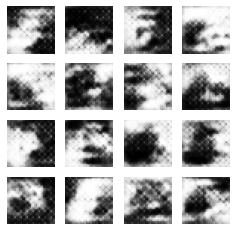

Time for training : 4036 sec


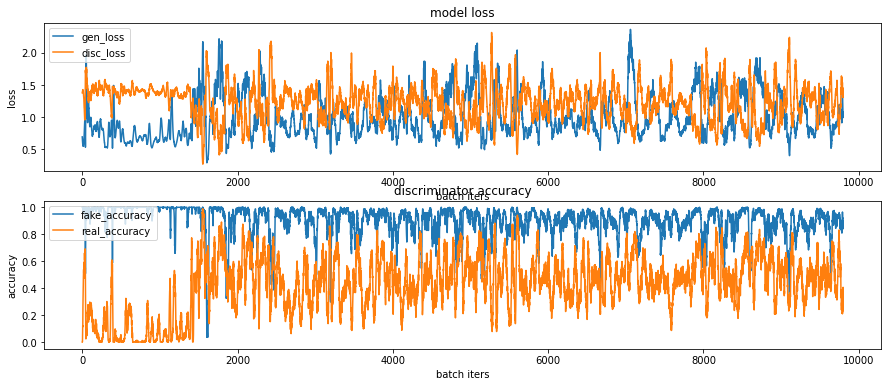

CPU times: user 1h 7min, sys: 27.4 s, total: 1h 7min 27s
Wall time: 1h 7min 17s


In [294]:
%%time
train(train_dataset, EPOCHS, save_every)

###### 학습 과정 시각화

In [295]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_gan.gif

-rw-r--r-- 1 root root 3107569 Sep  2 12:44 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_gan.gif


In [296]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

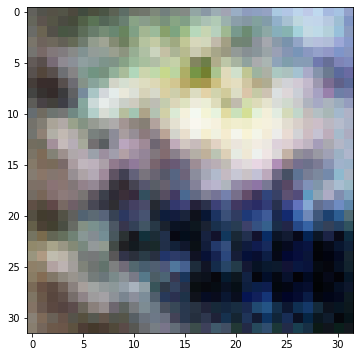

In [297]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

######  STEP 7. (optional) GAN 훈련 과정 개선하기

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

1번째 Epoch : 
- 초반에는 전부 Fake로 판별하는 듯, 초반의 Fake Accuracy가 1, Real Accuracy가 0을 기록
- gen_loss는 우하향, disc_loss는 우상향하는 모습을 보임
             
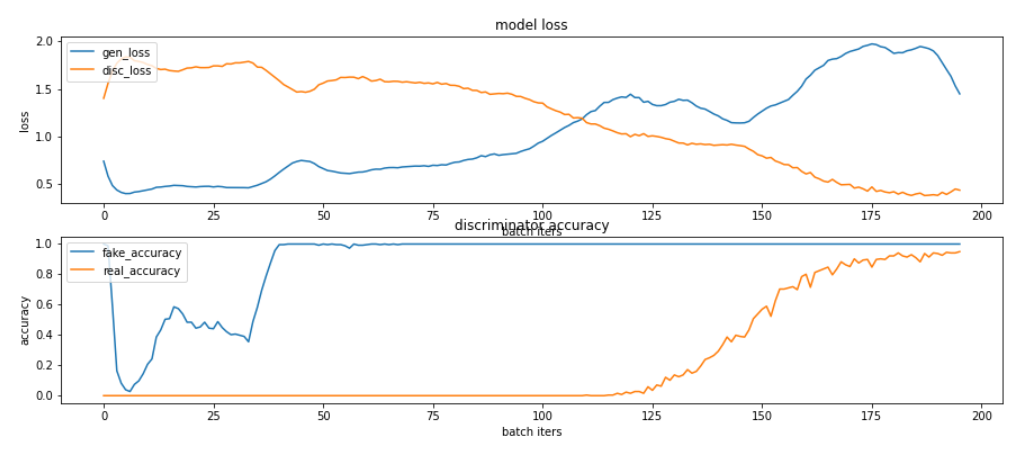

10번째 Epoch :  
- Fake Accuracy 값이 1에 가깝게 나타나고, Real Accuracy는 0에서 0.6 정도로 상승하는 모습을 보임
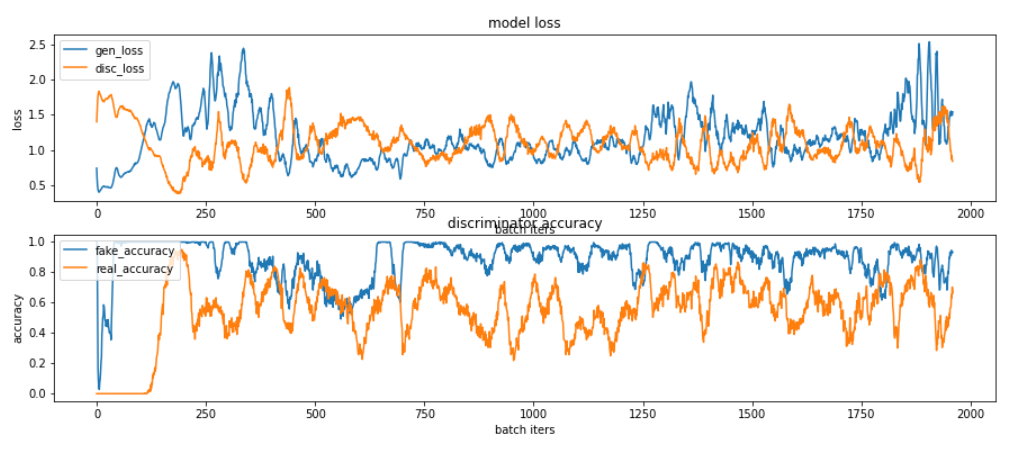

20번째 Epoch :  
- Fake Accuracy 값이 1에 가깝게 나타나고, Real Accuracy는 0에서 0.6 정도로 상승하는 모습을 보인 것이 10번째 Epoch과 큰 차이 없음
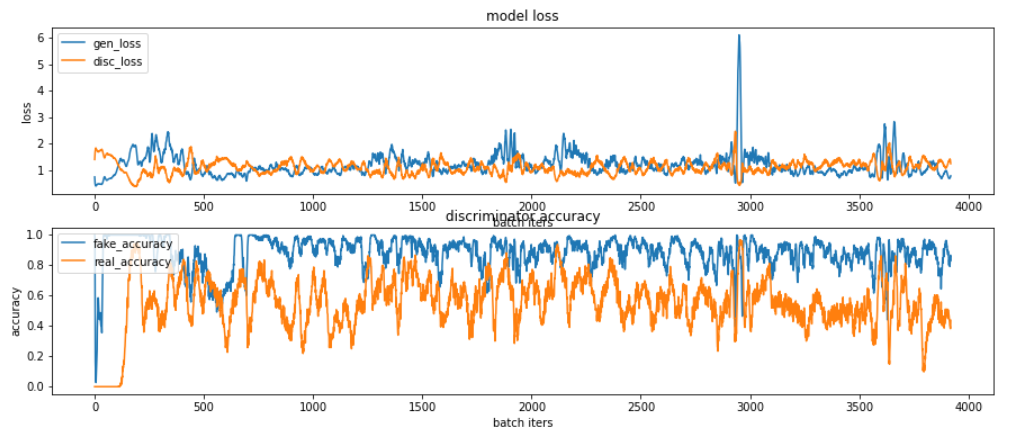

50번째 Epoch :  
- Fake Accuracy의 값이 여전히 감소하지 않음 
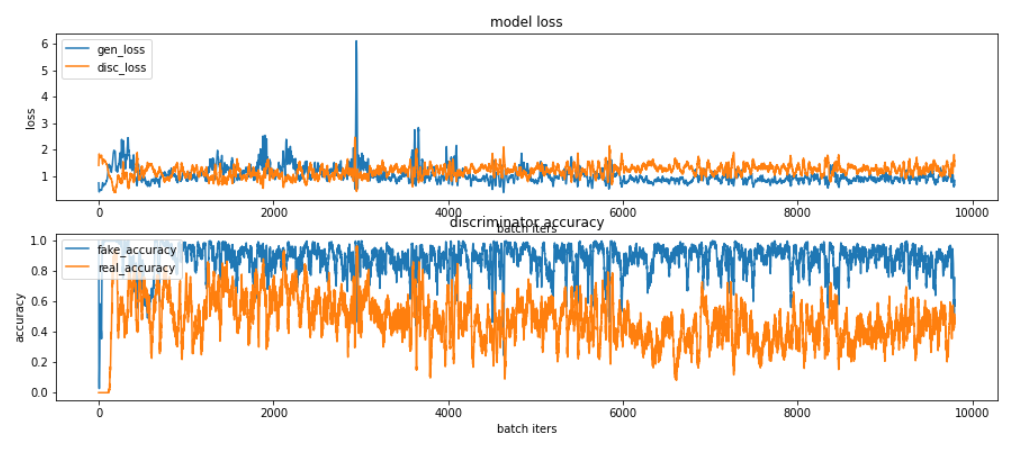

최초 생성자 모델 설계
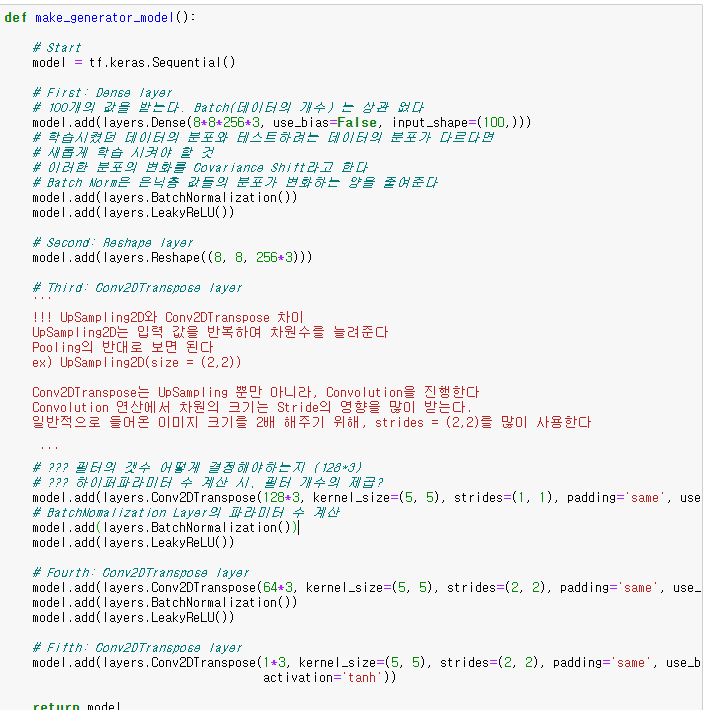

최초 생성자 모델에 의한 Output이 다음과 같이,
뚜렷한 이미지가 아닌, 굉장히 노이즈가 많은 모습을 보였음 
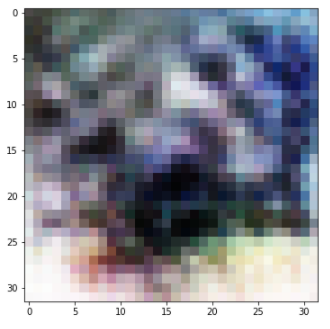

이에 대해, 첫 ConvolutionTranspose2D 레이어의 stride가 1로 겹치는 구간이 많아서 그런 것이 아닐까 
추측을 해보았음

이로 인해,stride를 2로 바꾸어 다시 학습

Epoch = 50 일 때, 큰 차이 없음 

###### Epoch 250 

다음과 같이, 사물들이 형체를 보인다
Step에 따라, 강아지나 고양이로 보이는 결과들이 보였으나, 여전히 기대이하
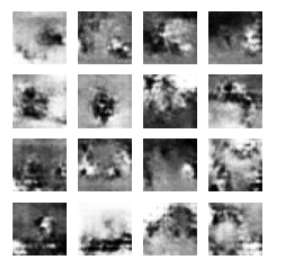

Fake Accuracy가 1에서 별로 안떨어지는 것은 
생성자에 랜덤한 값을 넣어 생성시킨 이미지를 판별한 값이
대부분 0.5 미만으로 나온다는 것이므로, 단순히 Epoch을 증가시키기 보다는
Generator 모델에 수정이 필요하다 

이미지를 -1에서 1 사이로 정규화를 해서 
Leaky ReLu 대신에 tanh를 써보면 어떨까해서 
Generator의 Leaky ReLu를 tanh로 바꿔 보았는데
결과는 참혹
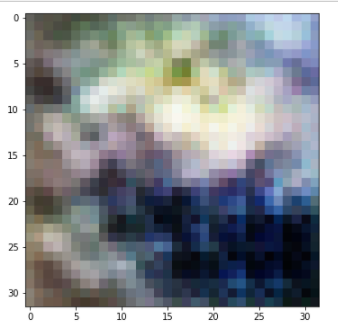

Leaky ReLu 층이 여러 차원 입력 값 중 유의미한 값들을 증폭? 선택? 하는 역할을 하는데 
tanh로 바꾸면서 그러한 역할이 줄어들어 그런 것으로 생각된다

Generator 모델 구성에 대해 더 연구가 필요하나 모델 트레이닝 시간이 과도하게 소요되어 
더 공부할 필요가 있을 것 같다